# Analysis of the Vostok data
The seasonal-diurnal diagram, its hourly cross-sections, possible role of adjustments for various factors

The source code of Figures 1.2, 1.3, 1.5, 1.S1, 1.S2 and 1.S3

### Importing libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.transforms as tf
from matplotlib import cm, colors, colormaps

import numpy as np
import pandas as pd
import scipy.stats as st

### Loading source PG datasets

In [2]:
# potential gradient values measured at Vostok station in 1998–2001
# adjusted for local meteorological and solar wind influences
# units are V·m^(−1)
# source: Burns et al. (2012), Table 2

vostok_old_data = (
    np.array([195, 201, 205, 192, 188, 195,
              209, 198, 209, 195, 193, 192])
)

In [3]:
# potential gradient values measured at Vostok station in 1998–2001
# units are V·m^(−1)
# source: Burns et al. (2012), Table 2

vostok_old_data_unadjusted = (
    np.array([195 - (23 - 0.1 - 1.4 + 10),
              201 - (20 - 0.1 - 1.5 + 7),
              205 - (8 - 1.5 - 0.1 + 6),
              192 - (1.0 - 1.6 + 1.5 + 4.9),
              188 - (-0.9 - 1.0 + 0.9 + 2.2),
              195 - (2.4 + 1.2 - 1.6 + 2.7),
              209 - (0.4 + 2.4 + 0.2 + 2.2),
              198 - (0.1 - 1.2 + 1.5 + 1.9),
              209 - (-0.1 - 0.1 + 1.0 + 4.9),
              195 - (8 - 0.2 + 1.7 + 4.4),
              193 - (20 + 0.1 - 0.7 + 7),
              192 - (23 + 0.2 - 0.6 + 8)])
)

In [4]:
# loading hourly data derived from 10-s averages
# "Field" column contains PG values (in V/m) without scaling and calibration
df_10s = pd.read_csv(
    "./data/Vostok/vostok_hourly_from_10_s_without_calibration_and_empty.tsv",
    sep="\t", parse_dates=["Datetime"]
).set_index("Datetime")

# adding a new column "Mark" to label this dataframe’s data
# as originating from 10-s averages
df_10s["Mark"] = "10s"

In [5]:
# loading hourly data derived from 5-min averages
# "Field" column contains PG values (in V/m) without scaling and calibration
df_5min = pd.read_csv(
    "./data/Vostok/vostok_hourly_from_5_min_without_calibration_and_empty.tsv",
    sep="\t", parse_dates=["Datetime"]
).set_index("Datetime")

# Add a new column "Mark" to label this dataframe’s data
# as originating from 5-min averages
df_5min["Mark"] = "5min"

In [6]:
# loading the earlier data set (1998-2004)
earlier_df_src = pd.read_csv(
    "./data/Vostok/vostok_1998_2004_hourly_80percent_all.tsv",
    sep="\t", parse_dates=["Datetime"]
).set_index("Datetime")

In [7]:
# note that all the aforementioned files assume a 80%
# data availability per hour, which means that the hourly value
# was calculated only when at least 80% of the records were 
# available (at least 288 10-s averages or at least 9 5-min averages)

In [8]:
# combining the two dataframes:
# filling in gaps in the 10-s data with the 5-min data
df_src = df_10s.combine_first(df_5min)

### Taking form factors into account

In [9]:
# adding a new column "Factor" to introduce the form factor
# by which the source values should be divided;
# the factor gradually changes from `f_0` around 1 Jan 2006
# to `f_1` around 1 Dec 2024
f_0 = 3.
f_1 = 2.4
date_range = pd.date_range(start="2006-01-01", end="2024-12-01", freq="D")
values = np.linspace(f_0, f_1, len(date_range))

factor_df = pd.DataFrame({"Factor": values}, index=date_range)
df_src = df_src.join(factor_df.resample("H").ffill())

In [10]:
# Optional: one can divide the earlier data by 1.35
# to make equal the mean values of fair-weather histograms across data sets:
# earlier_df["Factor"] = 1.35

In [11]:
factor_df[5478:5479]

Factor
2020-12-31  2.524273

### Helper functions and variables for PG

In [12]:
def std_error(avg_val, avg_sqr, counter):
    """
    Estimate the standard error from the average value
    and the average value of the square.

    :param avg_val: the average value
    :param avg_sqr: the average square value
    :param counter: the size of the sample

    :return: the standard error
    """

    return np.sqrt((avg_sqr - avg_val**2) / (counter - 1))

In [13]:
def pass_fair_weather(DF):
    """
    Filter and adjust potential gradient (PG) data
    to represent fair-weather conditions.

    :param DF: the input dataframe which contains "Field" values of hourly
               averaged potential gradient (PG) data and may contain "Factor"
               values of the form factor (equal to 1 if not provided)

    :return: a dataframe with hourly data filtered to approximately represent
             only fair-weather days
    """

    df = DF.copy()

    # normalising "Field" values by "Factor" if provided
    if "Factor" in df:
        df["Field"] = df["Field"] / df["Factor"]

    # excluding records with non-positive PG values
    df = df[df["Field"] > 0]

    # excluding records with PG values > 300 V/m
    df = df[df["Field"] <= 300]

    # counting the number of valid hours per day and
    # retaining only the days with complete hourly data (24 counts)
    df["Count"] = df["Field"].resample("D").transform("count")
    df = df[df["Count"] == 24]

    # computing diurnal PG stats
    df["Emax"] = df["Field"].resample("D").transform("max")
    df["Emin"] = df["Field"].resample("D").transform("min")
    df["Emean"] = df["Field"].resample("D").transform("mean")

    # excluding the days with the peak-to-peak amplitude
    # exceeding 150% of the daily mean
    df["Var"] = (df["Emax"] - df["Emin"]) / df["Emean"]
    df = df[df["Var"] <= 1.5]

    # removing temporary columns used for calculations
    df = df[["Field"]]

    return df

In [14]:
def calculate_seasonal_var_params(df, key="Field"):
    """
    Compute the parameters necessary for assessing the seasonal 
    variability of the fair-weather potential gradient (PG).

    :param df: the input dataframe containing the selected data with
               a datetime index and at least one numerical column
    :param key: column label in `cond_df` which contains the PG data
                (default is "Field")

    :return: a list containing arrays of:
             monthly mean PG values, 
             counts of fair weather days and 
             adjusted monthly mean PG square values
    """

    # computing monthly mean values of the fair-weather PG
    mon_pg = df[key].groupby(
        df.index.month
    ).mean().reindex(np.arange(1, 13)).to_numpy().flatten()

    # counting the number of fair weather days for each month
    mon_counter = df[key].groupby(
        df.index.month
    ).count().reindex(np.arange(1, 13)).to_numpy().flatten()

    # computing monthly mean values of the square of fair-weather PG
    mon_pg_sqr = df[key].pow(2).groupby(
        df.index.month
    ).sum().reindex(np.arange(1, 13)).to_numpy().flatten() / mon_counter

    return [mon_pg, mon_counter, mon_pg_sqr]

In [15]:
# defining an array of abbreviated month names to use as labels
month_name = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]

### Applying fair weather criteria 

In [16]:
# applying the fair-weather filter to the new data set
# with a scale factor of 3 to normalise field values
df = pass_fair_weather(df_src)

# applying the fair-weather filter to the earlier data set
# with a scale factor of 1 for normalisation
earlier_df = pass_fair_weather(earlier_df_src)

### Resampling daily fair-weather datasets 

In [17]:
# resampling the filtered data to calculate daily mean fair-weather PG values,
# then dropping any days with missing data
# to ensure the completeness of the data set
daily_df = df.resample("D").mean().dropna()
daily_edf = earlier_df.resample("D").mean().dropna()

In [18]:
# saving intermediate data for use in other scripts
np.save(
    "./data/Vostok/vostok_diurnal_2006_2020.npy",
    df.groupby(df.index.hour).mean().dropna().to_numpy().flatten()
)

### Figure 1.2
Seasonal variation (based on the new data) for different years

In [19]:
# calculating seasonal variation parameters for specific years: 
# the average fair-weather PG, the number of fair-weather days,
# the average square of the fair-weather PG
data, data_counter, data_sqr = np.array(
    [
        calculate_seasonal_var_params(daily_df),
        calculate_seasonal_var_params(daily_df[daily_df.index.year <= 2012]),
        calculate_seasonal_var_params(daily_df[daily_df.index.year > 2012])
    ]
).swapaxes(0,1)

data_counter = data_counter.astype(int)

# saving intermediate data for use in other scripts
np.savez(
    "./data/Vostok/vostok_2006_2020_results.npz",
    mean=data, counter=data_counter, sqr=data_sqr
)

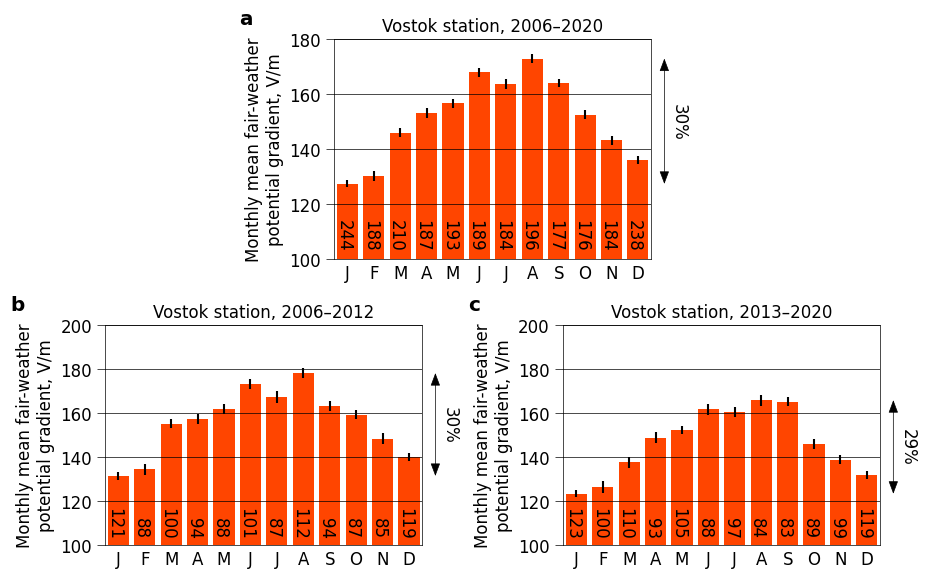

In [20]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = [None for _ in range(3)]
ax[0] = fig.add_subplot(4, 4, (2, 3))
for n in range(2, 4):
    ax[n-1] = fig.add_subplot(4, 4, (2*n + 1, 2*n + 2))

low = [100] * 3
high = [180] + [200] * 2
step = [20] * 3
coeff = [1] * 3
caption = ["Vostok station, 2006–2020",
           "Vostok station, 2006–2012",
           "Vostok station, 2013–2020"]
col = ["orangered"] * 3

for n in range(3):
    for axis in ["top", "bottom", "left", "right"]:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis="y")
    ax[n].tick_params(length=0, width=0.5, axis="x")
    ax[n].grid(color="0.", linewidth=0.5, axis="y")

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize="large", va="top")

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize="large")
    ax[n].set_ylabel("Monthly mean fair-weather\npotential gradient, V/m",
                     fontsize="large")

    ax[n].set_title(caption[n], fontsize="large")

    ax[n].annotate("", xy=(12, np.min(data[n])), xycoords="data",
                   xytext=(12, np.max(data[n])), textcoords="data",
                   annotation_clip=False,
                   arrowprops=dict(
                       arrowstyle="<|-|>,head_length=0.8,head_width=0.3",
                       patchA=None, patchB=None, shrinkA=0., shrinkB=0.,
                       connectionstyle="arc3,rad=0.", fc="black",
                       linewidth=0.5
                   ))

    ampl = (np.max(data[n]) - np.min(data[n])) / \
        np.sum(data[n] * data_counter[n]) * np.sum(data_counter[n])
    ax[n].text(12.2, (np.min(data[n]) + np.max(data[n])) / 2,
               f"{ampl * 100:.0f}%",
               fontsize="large", ha="left", va="center", rotation=270)

for n in range(3):
    ax[n].bar(np.arange(12), data[n],
              yerr=std_error(data[n],
                             data_sqr[n],
                             data_counter[n]),
              width=0.8, color=col[n])

for n in range(3):
    ax[n].text(-0.3, 1.05, chr(ord("a") + n),
               fontsize="x-large",
               fontweight="semibold", ha="left", va="bottom",
               transform=ax[n].transAxes)

fig.subplots_adjust(hspace=0.3, wspace=1.6)

for n in range(3):
    for m in range(12):
        ax[n].annotate(f"{data_counter[n, m]}",
                       xy=(m-0.15, ax[n].get_ylim()[0] + 3),
                       rotation=270, ha="center", va="bottom",
                       fontsize="large", color="0.")

fig.savefig("figures/pg_total_partial.eps", bbox_inches="tight")

### Figure 1.S1
Seasonal variation (based on the new data) for individual years

In [21]:
# calculating seasonal variation parameters for specific years: 
# the average fair-weather PG, the number of fair-weather days,
# the average square of the fair-weather PG
data, data_counter, data_sqr = np.array(
    [
        calculate_seasonal_var_params(daily_df[daily_df.index.year == Y])
        for Y in range(2006, 2021)
    ]
).swapaxes(0,1)

data_counter = np.nan_to_num(data_counter, nan=0.).astype(int)

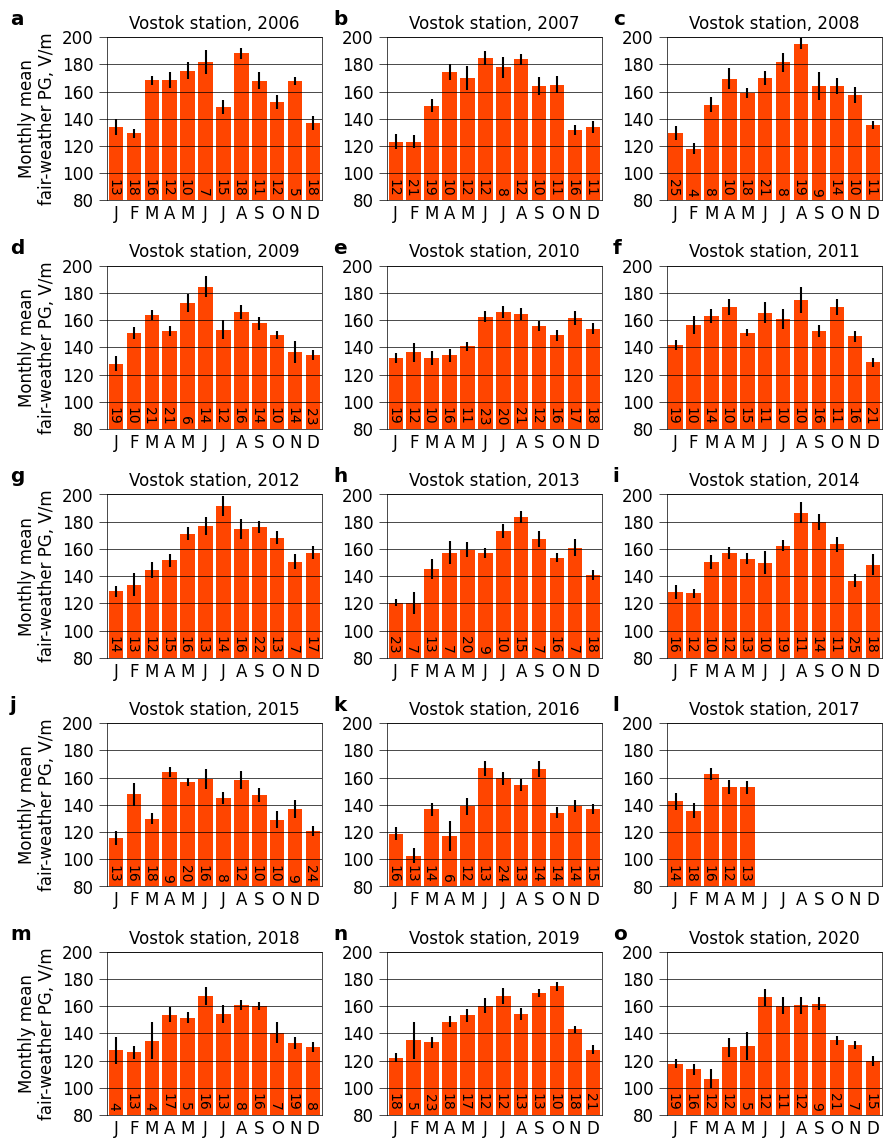

In [22]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = [None for _ in range(15)]
for n in range(15):
    ax[n] = fig.add_subplot(5, 3, n + 1)

low = [80] * 15
high = [200] * 15
step = [20] * 15
coeff = [1] * 15
caption = [f'Vostok station, {x:d}' for x in range(2006, 2021)]
col = ["orangered"] * 15

for n in range(15):
    for axis in ["top", "bottom", "left", "right"]:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis="y")
    ax[n].tick_params(length=0, width=0.5, axis="x")
    ax[n].grid(color="0.", linewidth=0.5, axis="y")

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize="large", va="top")

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize="large")
    if n % 3 == 0:
        ax[n].set_ylabel("Monthly mean\nfair-weather PG, V/m",
                         fontsize="large")

    ax[n].set_title(caption[n], fontsize="large")

for n in range(15):
    ax[n].bar(np.arange(12), data[n],
              yerr=std_error(data[n],
                             data_sqr[n],
                             data_counter[n]),
              width=0.8, color=col[n])

for n in range(15):
    ax[n].text(-0.45 if n % 3 == 0 else -0.25, 1.05, chr(ord("a") + n),
               fontsize="x-large",
               fontweight="semibold", ha="left", va="bottom",
               transform=ax[n].transAxes)

fig.subplots_adjust(hspace=0.4, wspace=0.3)

for n in range(15):
    for m in range(12):
        if data_counter[n, m] > 0:
            ax[n].annotate(f"{data_counter[n, m]}",
                           xy=(m-0.15, ax[n].get_ylim()[0] + 3),
                           rotation=270, ha="center", va="bottom",
                           fontsize="medium", color="0.")

fig.savefig("figures/pg_individual.eps", bbox_inches="tight")

### Figure 1.S2
Seasonal variation (based on the new data) for individual 3-year periods

In [23]:
# calculating seasonal variation parameters for specific years: 
# the average fair-weather PG, the number of fair-weather days,
# the average square of the fair-weather PG
data, data_counter, data_sqr = np.array(
    [
        calculate_seasonal_var_params(
            daily_df[(daily_df.index.year >= Y) & (daily_df.index.year < Y + 3)]
        )
        for Y in range(2006, 2019, 3)
    ]
).swapaxes(0,1)

data_counter = data_counter.astype(int)

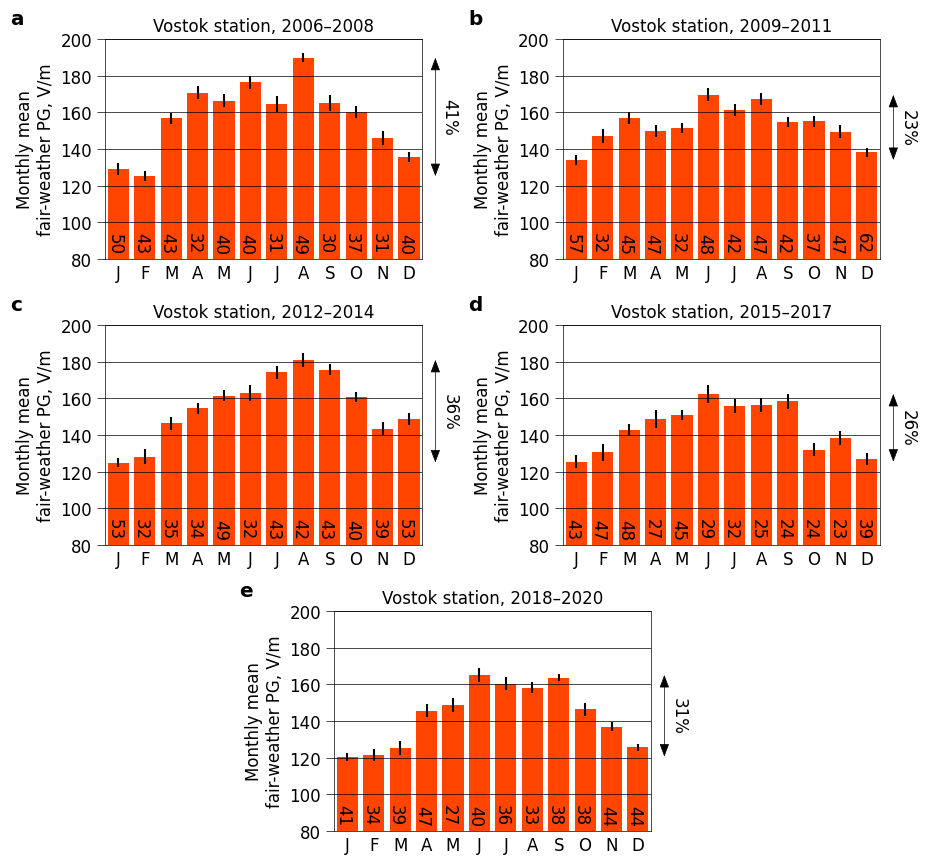

In [24]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = [None for _ in range(5)]
for n in range(4):
    ax[n] = fig.add_subplot(4, 4, (2*n + 1, 2*n + 2))
ax[4] = fig.add_subplot(4, 4, (10, 11))

low = [80] * 5
high = [200] * 5
step = [20] * 5
coeff = [1] * 5
caption = [f'Vostok station, {x:d}–{x+2:d}' for x in range(2006, 2019, 3)]
col = ["orangered"] * 5

for n in range(5):
    for axis in ["top", "bottom", "left", "right"]:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis="y")
    ax[n].tick_params(length=0, width=0.5, axis="x")
    ax[n].grid(color="0.", linewidth=0.5, axis="y")

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize="large", va="top")

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize="large")
    ax[n].set_ylabel("Monthly mean\nfair-weather PG, V/m",
                     fontsize="large")

    ax[n].set_title(caption[n], fontsize="large")

    ax[n].annotate("", xy=(12, np.min(data[n])), xycoords="data",
                   xytext=(12, np.max(data[n])), textcoords="data",
                   annotation_clip=False,
                   arrowprops=dict(
                       arrowstyle="<|-|>,head_length=0.8,head_width=0.3",
                       patchA=None, patchB=None, shrinkA=0., shrinkB=0.,
                       connectionstyle="arc3,rad=0.", fc="black",
                       linewidth=0.5
                   ))

    ampl = (np.max(data[n]) - np.min(data[n])) / \
        np.sum(data[n] * data_counter[n]) * np.sum(data_counter[n])
    ax[n].text(12.2, (np.min(data[n]) + np.max(data[n])) / 2,
               f"{ampl * 100:.0f}%",
               fontsize="large", ha="left", va="center", rotation=270)

for n in range(5):
    ax[n].bar(np.arange(12), data[n],
              yerr=std_error(data[n],
                             data_sqr[n],
                             data_counter[n]),
              width=0.8, color=col[n])

for n in range(5):
    ax[n].text(-0.3, 1.05, chr(ord("a") + n),
               fontsize="x-large",
               fontweight="semibold", ha="left", va="bottom",
               transform=ax[n].transAxes)

fig.subplots_adjust(hspace=0.3, wspace=1.6)

for n in range(5):
    for m in range(12):
        ax[n].annotate(f"{data_counter[n, m]}",
                       xy=(m-0.15, ax[n].get_ylim()[0] + 3),
                       rotation=270, ha="center", va="bottom",
                       fontsize="large", color="0.")

fig.savefig("figures/pg_3_years.eps", bbox_inches="tight")

### Figure 1.3
A diurnal-seasonal siagram

In [25]:
# creating a diurnal-seasonal array by grouping the data by hours and months,
# then calculating the mean fair-weather PG value for each combination
ds_df = df.groupby([df.index.hour, df.index.month]).mean()
ds_df.index.set_names(["hour", "month"], inplace=True)

vostok_pg_data_to_plot = ds_df.values.reshape(24, 12).T
vostok_mean_pg_data = vostok_pg_data_to_plot.mean(axis=1).reshape(12, 1)

In [26]:
np.amin(vostok_pg_data_to_plot)

108.06793219204636

In [27]:
np.amax(vostok_pg_data_to_plot)

198.76679783526467

In [28]:
# calculating seasonal variation parameters for specific hours: 
# the average fair-weather PG, the number of fair-weather days,
# the average square of the fair-weather PG
data, data_counter, data_sqr = np.array(
    [
        calculate_seasonal_var_params(daily_df),
        calculate_seasonal_var_params(df[df.index.hour == 3]),
        calculate_seasonal_var_params(df[df.index.hour == 9]),
        calculate_seasonal_var_params(df[df.index.hour == 15]),
        calculate_seasonal_var_params(df[df.index.hour == 21]),
    ]
).swapaxes(0, 1)

data_counter = data_counter.astype(int)

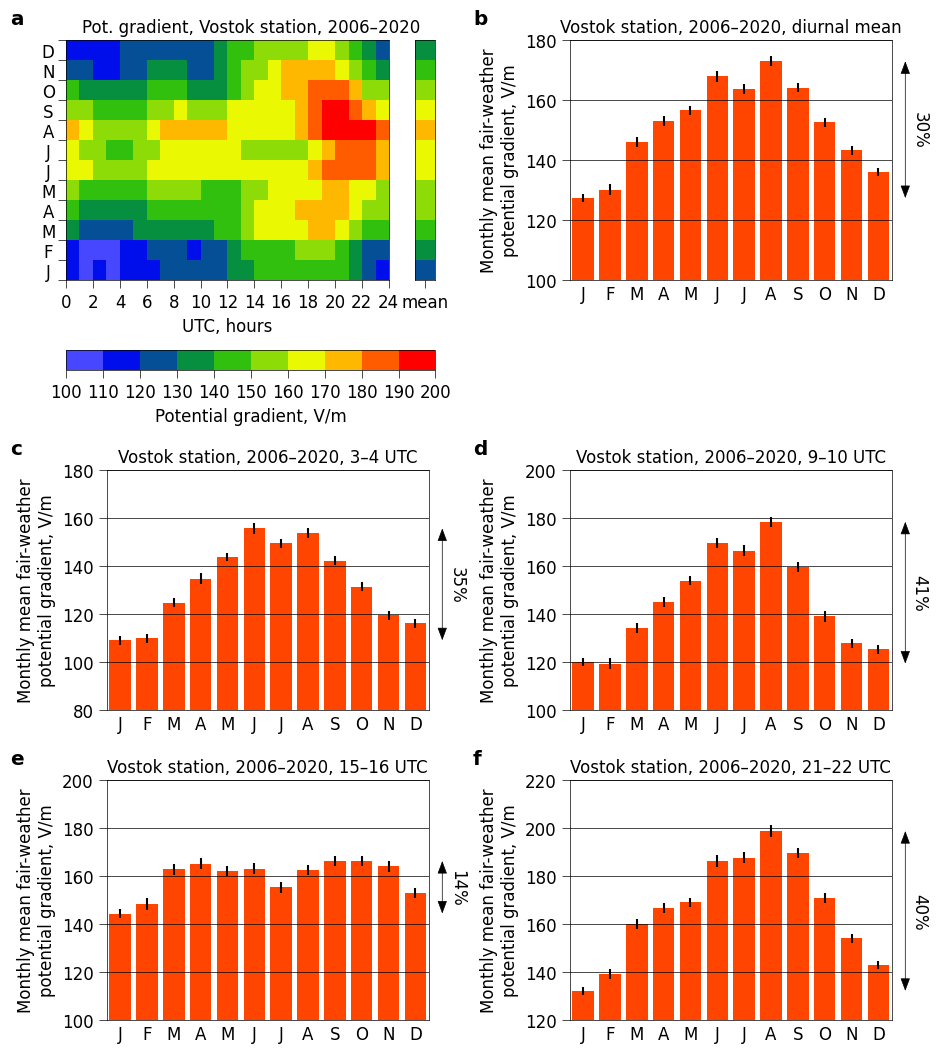

In [29]:
fig_width = 10
fig_height = 11

height = 12
heightC = 1
heightB = 12
hsep1 = 3.5
hsep2 = 5
hsep3 = 3.5
hsp = 3
tot_height = height + heightC + 2 * heightB + hsep1 + hsep2 + hsep3 + 2 * hsp

width = 12
widthM = heightC/tot_height * fig_height/fig_width
widthB = 12
wsep1 = 1
wsep2 = 3.5
wsp = 4
wshift = 1.5
tot_width = (width + widthB + wsep1 + wsep2 + 2 * wsp) / (1 - widthM)
widthM *= tot_width

fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=False)

ax = fig.add_axes(
    (
        (wsp - wshift) / tot_width,
        (hsp + 2 * heightB + hsep2 + hsep3 + heightC + hsep1) / tot_height,
        width / tot_width,
        height / tot_height
    )
)
axM = fig.add_axes(
    (
        (wsp - wshift + width + wsep1) / tot_width,
        (hsp + 2 * heightB + hsep2 + hsep3 + heightC + hsep1) / tot_height,
        widthM / tot_width,
        height / tot_height
    )
)

axB = [None for _ in range(5)]

axB[0] = fig.add_axes(
    (
        (wsp + width + wsep1 + widthM + wsep2) / tot_width,
        (hsp + heightB + hsep2 + hsep3 + heightC + hsep1 + height) / tot_height,
        widthB / tot_width,
        heightB / tot_height
    )
)
for n in range(2):
    axB[3 - 2*n] = fig.add_axes(
        (
            wsp / tot_width,
            (hsp + n * (heightB + hsep3)) / tot_height,
            widthB / tot_width,
            heightB / tot_height
        )
    )
    axB[4 - 2*n] = fig.add_axes(
        (
            (wsp + width + wsep1 + widthM + wsep2) / tot_width,
            (hsp + n * (heightB + hsep3)) / tot_height,
            widthB / tot_width,
            heightB / tot_height
        )
    )

caption = "Pot. gradient, Vostok station, 2006–2020"

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(length=6, width=0.5)
ax.tick_params(length=0, width=0.5, which="minor")
ax.grid(False)

ax.set_xlim((0, 24))
ax.set_xticks(np.arange(0, 25, 2))
ax.set_xticklabels(np.arange(0, 25, 2), fontsize="large")
ax.set_xlabel("UTC, hours", fontsize="large")

ax.set_ylim((0, 12))
ax.set_yticks(np.arange(0, 12.5, 1))
ax.set_yticks(np.arange(0.5, 12, 1), minor=True)
ax.set_yticklabels([])
ax.set_yticklabels(month_name, fontsize="large", ha="center",
                   minor=True)
tr = []
for label in ax.yaxis.get_majorticklabels():
    tr.append(label.get_transform())
for label in ax.yaxis.get_minorticklabels():
    label.set_transform(
        tr[0] + tf.ScaledTranslation(
            -0.05, 0, fig.dpi_scale_trans
        )
    )

for axis in ["top", "bottom", "left", "right"]:
    axM.spines[axis].set_linewidth(0.5)
axM.tick_params(length=0, width=0.5)
axM.tick_params(length=6, width=0.5, which="minor")
axM.grid(False)

axM.set_xlim((0, 1))
axM.set_xticks([])
axM.set_xticks([0.5], minor=True)
axM.set_xticklabels([])
axM.set_xticklabels(["mean"], fontsize="large", minor=True)

axM.set_ylim((0, 12))
axM.set_yticks([])
axM.set_yticklabels([])

lbl = ax.set_title(caption, fontsize="large")
pos = (width + wsep1 + widthM) / 2 / width
lbl.set_position((pos, 1.))

# the bounds of the colour bar (in V/m)
pg_bound = np.arange(100, 201, 10)

# the colours
colour_hour = np.array([[71, 71, 255], [1, 14, 236],
                        [4, 79, 149], [6, 143, 63], [49, 192, 13],
                        [142, 220, 7], [234, 249, 1], [255, 184, 0],
                        [255, 92, 0], [255, 0, 0]]) / 255

pg_cmap = colors.ListedColormap(colour_hour)
pg_norm = colors.BoundaryNorm(pg_bound, pg_cmap.N)

pg_cax = fig.add_axes(
    (
        (wsp - wshift) / tot_width,
        (hsp + 2 * heightB + hsep2 + hsep3) / tot_height,
        (width + wsep1 + widthM)  / tot_width,
        heightC / tot_height
    )
)
pg_cbar = fig.colorbar(cm.ScalarMappable(norm=pg_norm,
                                         cmap=pg_cmap),
                       cax=pg_cax, orientation="horizontal")
pg_cbar.outline.set_linewidth(0.5)
pg_cbar.ax.tick_params(length=6, width=0.5)
pg_cbar.set_ticks(pg_bound)
pg_cbar.ax.set_xticklabels(list(map(str,
                                    pg_bound.astype(int))),
                           fontsize="large")
pg_cbar.set_label("Potential gradient, V/m",
                  fontsize="large")

ax.imshow(vostok_pg_data_to_plot,
          cmap=pg_cmap, norm=pg_norm,
          extent=[0, 24, 12, 0], aspect="auto", interpolation="none",
          rasterized=True)

axM.imshow(vostok_mean_pg_data,
           cmap=pg_cmap, norm=pg_norm,
           extent=[0, 1, 12, 0], aspect="auto", interpolation="none",
           rasterized=True)

low = [100, 80, 100, 100, 120]
high = [180, 180, 200, 200, 220]
step = [20] * 5
coeff = [1] * 5
captionB = ["Vostok station, 2006–2020, diurnal mean",
            "Vostok station, 2006–2020, 3–4 UTC",
            "Vostok station, 2006–2020, 9–10 UTC",
            "Vostok station, 2006–2020, 15–16 UTC",
            "Vostok station, 2006–2020, 21–22 UTC"]

col = ["orangered"] * 5

for n in range(5):
    for axis in ["top", "bottom", "left", "right"]:
        axB[n].spines[axis].set_linewidth(0.5)
    axB[n].tick_params(length=6, width=0.5, axis="y")
    axB[n].tick_params(length=0, width=0.5, axis="x")
    axB[n].grid(color="0.", linewidth=0.5, axis="y")

    axB[n].set_xlim((-0.5, 11.5))
    axB[n].set_xticks(np.arange(12))
    axB[n].set_xticklabels(month_name, fontsize="large", va="top")

    axB[n].set_ylim((low[n], high[n]))
    axB[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    axB[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                      step[n]) / coeff[n]).astype(int),
                           fontsize="large")
    axB[n].set_ylabel("Monthly mean fair-weather\npotential gradient, V/m",
                      fontsize="large")

    axB[n].set_title(captionB[n], fontsize="large")

    axB[n].annotate("", xy=(12, np.min(data[n])), xycoords="data",
                    xytext=(12, np.max(data[n])), textcoords="data",
                    annotation_clip=False,
                    arrowprops=dict(
                        arrowstyle="<|-|>,head_length=0.8,head_width=0.3",
                        patchA=None, patchB=None, shrinkA=0., shrinkB=0.,
                        connectionstyle="arc3,rad=0.", fc="black",
                        linewidth=0.5
                    ))

    ampl = (np.max(data[n]) - np.min(data[n])) / \
        np.sum(data[n] * data_counter[n]) * np.sum(data_counter[n])
    axB[n].text(12.2, (np.min(data[n]) + np.max(data[n])) / 2,
                f"{ampl * 100:.0f}%",
                fontsize="large", ha="left", va="center", rotation=270)

for n in range(5):
    axB[n].bar(np.arange(12), data[n],
               yerr=std_error(data[n],
                              data_sqr[n],
                              data_counter[n]),
               width=0.8, color=col[n])

ax.text(-(0.3 * widthB - wshift)/width, 1 + 0.05 * heightB/height, "a",
        fontsize="x-large",
        fontweight="semibold", ha="left", va="bottom",
        transform=ax.transAxes)
for n in range(5):
    axB[n].text(-0.3, 1.05, chr(ord("b") + n),
                fontsize="x-large",
                fontweight="semibold", ha="left", va="bottom",
                transform=axB[n].transAxes)

fig.savefig("figures/pg_diurnal_seasonal.eps", bbox_inches="tight")

### Data adjustment using meteorological parameters and the solar-wind-imposed potential

In [30]:
# loading and filtering meteorological data from CSV files into separate
# dataframes, then joining them with the daily fair-weather PG dataframe
# to create a combined dataframe without missing values

temp_df = pd.read_csv(
    "./data/Vostok/vostok_daily_temp.csv",
    parse_dates=["UTC"]
).set_index("UTC")

# retaining only the days with complete data (4 counts)
temp_df = temp_df[temp_df["COUNT"] == 4][["T"]]

wind_df = pd.read_csv(
    "./data/Vostok/vostok_daily_wind.csv",
    parse_dates=["UTC"]
).set_index("UTC")

# retaining only the days with complete data (4 counts)
wind_df = wind_df[wind_df["COUNT"] == 4][["Ff"]]

pressure_df = pd.read_csv(
    "./data/Vostok/vostok_daily_pressure_mm_hg.csv",
    parse_dates=["UTC"]
).set_index("UTC")

# retaining only the days with complete data (4 counts)
pressure_df = pressure_df[pressure_df["COUNT"] == 4][["Po"]]

meteo_df = temp_df.join([wind_df, pressure_df, daily_df]).dropna()

In [31]:
# calculating the anomalies for the fair-weather PG (`pg_anom`),
# temperature (`temp_anom`), wind speed (`wind_anom`) and
# pressure (`pres_anom`) based on a moving window of ±10 days

pg_anom = np.zeros((len(meteo_df.index)))
temp_anom = np.zeros((len(meteo_df.index)))
wind_anom = np.zeros((len(meteo_df.index)))
pres_anom = np.zeros((len(meteo_df.index)))

halfwidth = 10
for i in range(len(meteo_df.index)):
    sum_pg = 0
    sum_temp = 0
    sum_pres = 0
    sum_wind = 0
    counter = 0
    for j in range(max(i - halfwidth, 0),
                   min(i + halfwidth + 1, len(meteo_df.index))):
        if abs((meteo_df.index[j] - meteo_df.index[i]).days) <= halfwidth:
            sum_pg += meteo_df["Field"].iloc[j]
            sum_temp += meteo_df["T"].iloc[j]
            sum_wind += meteo_df["Ff"].iloc[j]
            sum_pres += meteo_df["Po"].iloc[j]
            counter += 1
    pg_anom[i] =  meteo_df["Field"].iloc[i] - (sum_pg / counter)
    temp_anom[i] =  meteo_df["T"].iloc[i] - (sum_temp / counter)
    wind_anom[i] =  meteo_df["Ff"].iloc[i] - (sum_wind / counter)
    pres_anom[i] =  meteo_df["Po"].iloc[i] - (sum_pres / counter)

In [32]:
# calculating correlation coefficients for temperature,
# wind speed and pressure anomalies against PG anomalies

for title, anom in zip(
    ["Temp", "Wind", "Pres"],
    [temp_anom, wind_anom, pres_anom]
):
    corr = np.corrcoef(anom, pg_anom)[0, 1]
    P = len(meteo_df.index)  # the number of points
    t = np.sqrt((P - 2) * corr**2 / (1 - corr*2))  # Student’s t-statistic
    print(
        f"{title}: Correlation coefficient: −{-corr:.2f}"
        if corr < 0
        else f"{title}: Correlation coefficient: {corr:.2f}"
    )
    print(f"{title}: Student’s t-statistic: {t:.2f}")
    print("\n")

P = len(meteo_df.index)  # the number of points
a = 0.05  # significance level
q = st.t.ppf(1 - a / 2, P - 2)  # critical value
r = q / np.sqrt(q**2 + P - 2)  # threshold correlation coefficient
print(f"Significance level: {a}")
print(f"Number of points: {P}")
print(f"Critical value of t (((P − 2)r^2/(1 − r^2))^(1/2)): {q}")
print(f"Threshold correlation coefficient: {r}")

Temp: Correlation coefficient: −0.09
Temp: Student’s t-statistic: 3.74


Wind: Correlation coefficient: 0.11
Wind: Student’s t-statistic: 5.95


Pres: Correlation coefficient: 0.00
Pres: Student’s t-statistic: 0.07


Significance level: 0.05
Number of points: 2198
Critical value of t (((P − 2)r^2/(1 − r^2))^(1/2)): 1.9610448392992756
Threshold correlation coefficient: 0.04181108274859215


In [33]:
# calculating linear regression coefficients for PG anomalies
# in terms of temperature and wind speed anomalies

temp_coeff, wind_coeff = np.linalg.lstsq(
    np.vstack([temp_anom, wind_anom]).T, pg_anom, rcond=None
)[0]

print(f"Temp: {temp_coeff}")
print(f"Wind: {wind_coeff}")

Temp: -0.5110842192373859
Wind: 2.8239818995071064


In [34]:
# adding the "CorrectedField" column (copy of the "Field" column)
# in the `meteo_df` by subtracting the linear fit based on
# temperature and wind anomalies

meteo_df["CorrectedField"] = (
    meteo_df["Field"]
    - temp_coeff * (meteo_df["T"] - meteo_df["T"].mean())
    - wind_coeff * (meteo_df["Ff"] - meteo_df["Ff"].mean())
)

In [35]:
# loading and filtering solar-wind-imposed potential data into a separate
# dataframe, then joining them with the daily fair-weather PG dataframe
# to create a combined dataframe without missing values

swip_df = pd.read_csv(
    "./data/Vostok/vostok_1998_2020_hourly_SWIP.txt",
    sep="\t", parse_dates=[[0, 1, 2, 3]], date_format="%Y %m %d %H",
    names=["Y", "M", "D", "H", "SWIP"]
).rename(columns={"Y_M_D_H": "Datetime"}).set_index("Datetime")

# counting the number of valid hours per day and
# retaining only the days with complete hourly data (24 counts)
swip_df["Count"] = swip_df["SWIP"].resample("D").transform("count")
swip_df = swip_df[swip_df["Count"] == 24][["SWIP"]]

solar_df = swip_df.join(daily_df).resample("D").mean().dropna()

In [36]:
# calculating the anomalies for the fair-weather PG
# (`pg_anom`) and solar-wind-imposed potential (`swip_anom`)
# based on a moving window of ±10 days

pg_anom = np.zeros((len(solar_df.index)))
swip_anom = np.zeros((len(solar_df.index)))

halfwidth = 10
for i in range(len(solar_df.index)):
    sum_pg = 0
    sum_swip = 0
    counter = 0
    for j in range(max(i - halfwidth, 0),
                   min(i + halfwidth + 1, len(solar_df.index))):
        if abs((solar_df.index[j] - solar_df.index[i]).days) <= halfwidth:
            sum_pg += solar_df["Field"].iloc[j]
            sum_swip += solar_df["SWIP"].iloc[j]
            counter += 1
    pg_anom[i] =  solar_df["Field"].iloc[i] - (sum_pg / counter)
    swip_anom[i] =  solar_df["SWIP"].iloc[i] - (sum_swip / counter)

In [37]:
# calculating correlation coefficients
# for solar-wind-imposed potential anomalies against PG anomalies

for title, anom in zip(
    ["SWIP"],
    [swip_anom]
):
    corr = np.corrcoef(anom, pg_anom)[0, 1]
    P = len(solar_df.index)  # the number of points
    t = np.sqrt((P - 2) * corr**2 / (1 - corr*2))  # Student’s t-statistic
    print(
        f"{title}: Correlation coefficient: −{-corr:.2f}"
        if corr < 0
        else f"{title}: Correlation coefficient: {corr:.2f}"
    )
    print(f"{title}: Student’s t-statistic: {t:.2f}")
    print("\n")

P = len(solar_df.index)  # the number of points
a = 0.05  # significance level
q = st.t.ppf(1 - a / 2, P - 2)  # critical value
r = q / np.sqrt(q**2 + P - 2)  # threshold correlation coefficient
print(f"Significance level: {a}")
print(f"Number of points: {P}")
print(f"Critical value of t (((P − 2)r^2/(1 − r^2))^(1/2)): {q}")
print(f"Threshold correlation coefficient: {r}")

SWIP: Correlation coefficient: 0.31
SWIP: Student’s t-statistic: 24.39


Significance level: 0.05
Number of points: 2297
Critical value of t (((P − 2)r^2/(1 − r^2))^(1/2)): 1.9609981900139433
Threshold correlation coefficient: 0.040899905007639514


In [38]:
# calculating linear regression coefficients for PG anomalies
# in terms of solar-wind-imposed potential anomalies

swip_coeff = np.linalg.lstsq(
    swip_anom[:, np.newaxis], pg_anom, rcond=None
)[0][0]

print(f"SWIP: {swip_coeff}")

SWIP: 0.74232838204607


In [39]:
# adding the "CorrectedField" column (copy of the "Field" column)
# in the `solar_df` by subtracting linear fits based on
# solar-wind-imposed potential anomalies

solar_df["CorrectedField"] = (
    solar_df["Field"]
    - swip_coeff * solar_df["SWIP"]
)

In [40]:
# combined data set
meteo_solar_df = temp_df.join(
    [wind_df, daily_df, swip_df.resample("D").mean()]
).dropna()

In [41]:
# adding the "CorrectedField" column (copy of the "Field" column)
# in the `meteo_solar_df` by subtracting linear fits based on
# temperature, wind and solar-wind-imposed potential anomalies

meteo_solar_df["CorrectedField"] = (
    meteo_solar_df["Field"]
    - temp_coeff * (meteo_solar_df["T"] - meteo_solar_df["T"].mean())
    - wind_coeff * (meteo_solar_df["Ff"] - meteo_solar_df["Ff"].mean())
    - swip_coeff * meteo_solar_df["SWIP"]
)

### Figure 1.5
The influence of adjustment PG for new and earlier Vostok datasets

In [42]:
# calculating seasonal variation parameters for specific data: 
# the average fair-weather PG, the number of fair-weather days,
# the average square of the fair-weather PG

data, data_counter, data_sqr = np.array(
    [
        [vostok_old_data_unadjusted, np.zeros(12).astype(int), np.zeros(12)],
        [vostok_old_data, np.zeros(12).astype(int), np.zeros(12)],
        calculate_seasonal_var_params(daily_df),
        calculate_seasonal_var_params(meteo_df, key="CorrectedField"),
        calculate_seasonal_var_params(solar_df, key="CorrectedField"),
        calculate_seasonal_var_params(meteo_solar_df, key="CorrectedField")
    ]
).swapaxes(0, 1)

data_counter = data_counter.astype(int)

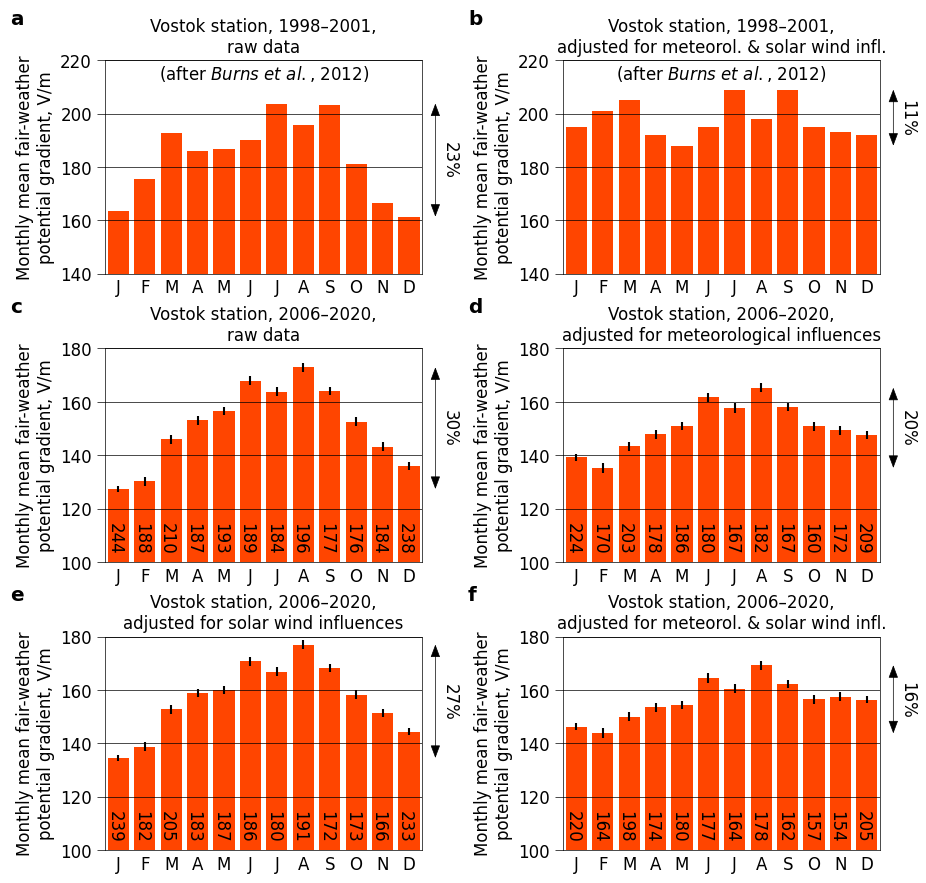

In [43]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = [None for _ in range(6)]
for n in range(6):
    ax[n] = fig.add_subplot(4, 4, (2*n + 1, 2*n + 2))

low = [140] * 2 + [100] * 4
high = [220] * 2 + [180] * 4
step = [20] * 6
coeff = [1] * 6

caption = ["Vostok station, 1998–2001,\nraw data",
           "Vostok station, 1998–2001,\nadjusted for meteorol. & solar wind infl.",
           "Vostok station, 2006–2020,\nraw data",
           "Vostok station, 2006–2020,\nadjusted for meteorological influences",
           "Vostok station, 2006–2020,\nadjusted for solar wind influences",
           "Vostok station, 2006–2020,\nadjusted for meteorol. & solar wind infl."]
col = ["orangered"] * 6

for n in range(6):
    for axis in ["top", "bottom", "left", "right"]:
        ax[n].spines[axis].set_linewidth(0.5)
    ax[n].tick_params(length=6, width=0.5, axis="y")
    ax[n].tick_params(length=0, width=0.5, axis="x")
    ax[n].grid(color="0.", linewidth=0.5, axis="y")

    ax[n].set_xlim((-0.5, 11.5))
    ax[n].set_xticks(np.arange(12))
    ax[n].set_xticklabels(month_name, fontsize="large", va="top")

    ax[n].set_ylim((low[n], high[n]))
    ax[n].set_yticks(np.arange(low[n], high[n] + step[n] / 2, step[n]))
    ax[n].set_yticklabels((np.arange(low[n], high[n] + step[n] / 2,
                                     step[n]) / coeff[n]).astype(int),
                          fontsize="large")
    ax[n].set_ylabel("Monthly mean fair-weather\npotential gradient, V/m",
                     fontsize="large")

    ax[n].set_title(caption[n], fontsize="large")
    if np.sum(data_counter[n]) == 0:
        ax[n].text(0.5,
                   1 - 0.01
                   * (ax[n].get_position().x1 - ax[n].get_position().x0)
                   / (ax[n].get_position().y1 - ax[n].get_position().y0)
                   * fig.get_size_inches()[0] / fig.get_size_inches()[1],
                   "(after $\it{Burns~et~al.}$, 2012)",
                   fontsize="large", ha="center", va="top",
                   transform=ax[n].transAxes)

    ax[n].annotate("", xy=(12, np.min(data[n])), xycoords="data",
                   xytext=(12, np.max(data[n])), textcoords="data",
                   annotation_clip=False,
                   arrowprops=dict(
                       arrowstyle="<|-|>,head_length=0.8,head_width=0.3",
                       patchA=None, patchB=None, shrinkA=0., shrinkB=0.,
                       connectionstyle="arc3,rad=0.", fc="black",
                       linewidth=0.5
                   ))
    if np.sum(data_counter[n]) == 0:
        ampl = (np.max(data[n]) - np.min(data[n])) / np.mean(data[n])
    else:
        ampl = (np.max(data[n]) - np.min(data[n])) / \
            np.sum(data[n] * data_counter[n]) * np.sum(data_counter[n])
    ax[n].text(12.2, (np.min(data[n]) + np.max(data[n])) / 2,
               f"{ampl * 100:.0f}%",
               fontsize="large", ha="left", va="center", rotation=270)

fig.align_ylabels([ax[0], ax[2], ax[4]])
fig.align_ylabels([ax[1], ax[3], ax[5]])

for n in range(6):
    if np.sum(data_counter[n]) == 0:
        ax[n].bar(np.arange(12), data[n],
          width=0.8, color=col[n])
    else:
        ax[n].bar(np.arange(12), data[n],
                  yerr=std_error(data[n],
                                 data_sqr[n],
                                 data_counter[n]),
                  width=0.8, color=col[n])

for n in range(6):
    ax[n].text(-0.3, 1.15, chr(ord("a") + n), fontsize="x-large",
               fontweight="semibold", ha="left", va="bottom",
               transform=ax[n].transAxes)

fig.subplots_adjust(hspace=0.35, wspace=1.6)

for n in range(6):
    if np.sum(data_counter[n]) > 0:
        for m in range(12):
            ax[n].annotate(f"{data_counter[n, m]}",
                           xy=(m-0.15, ax[n].get_ylim()[0] + 3),
                           rotation=270, ha="center", va="bottom",
                           fontsize="large", color="0.")

fig.savefig("figures/pg_corrected.eps", bbox_inches="tight")

### Figure 1.S3
Our own analysis of the earlier Vostok data

In [44]:
# calculating seasonal variation parameters for specific data: 
# the average fair-weather PG, the number of fair-weather days,
# the average square of the fair-weather PG

data, data_counter, data_sqr = calculate_seasonal_var_params(
    daily_edf[daily_edf.index.year <= 2001]
)

data_counter = data_counter.astype(int)

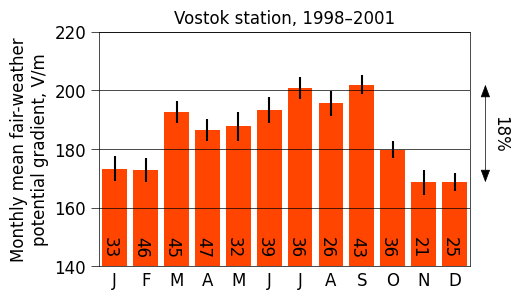

In [45]:
fig = plt.figure(figsize=(10, 14), constrained_layout=False)
ax = fig.add_subplot(4, 4, (1, 2))

low = 140
high = 220
step = 20
coeff = 1

caption = "Vostok station, 1998–2001"
col = "orangered"

for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(0.5)
ax.tick_params(length=6, width=0.5, axis="y")
ax.tick_params(length=0, width=0.5, axis="x")
ax.grid(color="0.", linewidth=0.5, axis="y")

ax.set_xlim((-0.5, 11.5))
ax.set_xticks(np.arange(12))
ax.set_xticklabels(month_name, fontsize="large", va="top")

ax.set_ylim((low, high))
ax.set_yticks(np.arange(low, high + step / 2, step))
ax.set_yticklabels((np.arange(low, high + step / 2,
                              step) / coeff).astype(int),
                   fontsize="large")
ax.set_ylabel("Monthly mean fair-weather\npotential gradient, V/m",
              fontsize="large")

ax.set_title(caption, fontsize="large")

ax.annotate("", xy=(12, np.min(data)), xycoords="data",
            xytext=(12, np.max(data)), textcoords="data",
            annotation_clip=False,
            arrowprops=dict(
                arrowstyle="<|-|>,head_length=0.8,head_width=0.3",
                patchA=None, patchB=None, shrinkA=0., shrinkB=0.,
                connectionstyle="arc3,rad=0.", fc="black",
                linewidth=0.5
            ))
ampl = (np.max(data) - np.min(data)) / \
    np.sum(data * data_counter) * np.sum(data_counter)
ax.text(12.2, (np.min(data) + np.max(data)) / 2,
        f"{ampl * 100:.0f}%",
        fontsize="large", ha="left", va="center", rotation=270)

ax.bar(np.arange(12), data,
       yerr=std_error(data,
                      data_sqr,
                      data_counter),
       width=0.8, color=col)

for m in range(12):
    ax.annotate(f"{data_counter[m]}",
                xy=(m-0.15, ax.get_ylim()[0] + 3),
                rotation=270, ha="center", va="bottom",
                fontsize="large", color="0.")

fig.savefig("figures/pg_earlier.eps", bbox_inches="tight")